In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

In [2]:
df = pd.read_csv("data/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Análisis exploratorio

In [4]:
df.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

In [5]:
df.shape

(6362620, 11)

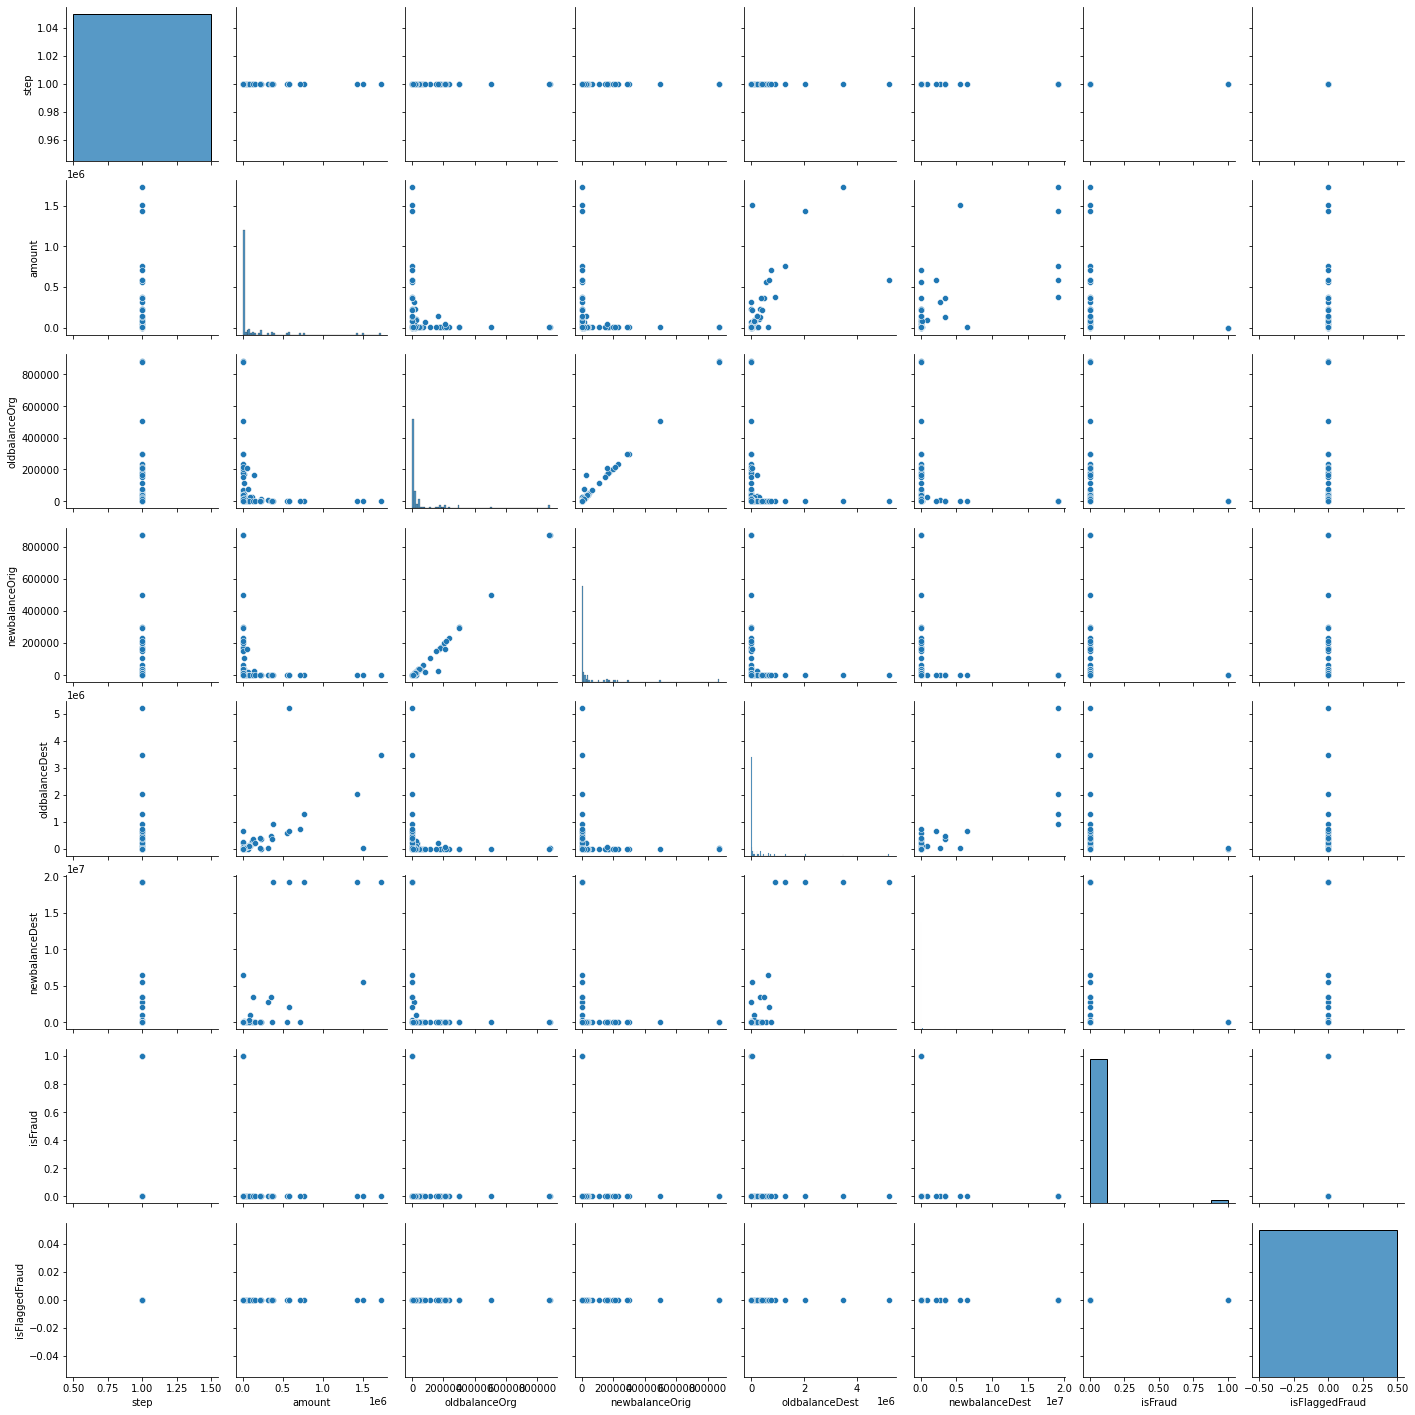

In [6]:
sns.pairplot(df[:100])

Features:

* step: represents a unit of time where 1 step equals 1 hour
* type: type of online transaction
* amount: the amount of the transaction
* nameOrig: customer starting the transaction
* oldbalanceOrg: balance before the transaction
* newbalanceOrig: balance after the transaction
* nameDest: recipient of the transaction
* oldbalanceDest: initial balance of recipient before the transaction
* newbalanceDest: the new balance of recipient after the transaction
* isFraud: fraud transaction

In [ ]:
# De la doc de SKlearn:
# Clone does a deep copy of the model in an estimator without actually copying attached data. 
# It yields a new estimator with the same parameters that has not been fitted on any data.
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Modelos a ensayar.
models = [
    ("RandomForest", RandomForestClassifier(n_estimators=50, random_state=42)),
    ("LogisticRegressionCV", LogisticRegressionCV(random_state=42, solver='lbfgs', max_iter=150)),
    ("RandomForest_class_weight", RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')),
    ("LogisticRegressionCV_class_weight", LogisticRegressionCV(random_state=42, solver='lbfgs', max_iter=150, class_weight='balanced'))
]

# Aquí almacenaremos los resultados.
results = {}
models_trained = {}

ganancia_total = total_gain(y_test, X_test['amount'])
# Etrenamos cada modelo y almacenamos los resultados.
for m in models:
    model_name = m[0]
    results[model_name] = {}
    model = clone(m[1])
    
    # Versión sin reducir sin over sampling
    model.fit(X_train, y_train)
    # Utilizamos el método de predicción en los datos de prueba
    predictions = model.predict(X_test)
    ganancia = gain(predictions, y_test, X_test['amount'])
    ganancia = (ganancia / ganancia_total) * 100
    results[model_name]["no_red_test_gain"] = str(ganancia)
    models_trained[model_name]['no_red'] = model
    
    # Versión reducida sin oversampling
    model = clone(m[1])
    model.fit(X_train[important_columns], y_train)
    # Utilizamos el método de predicción en los datos de prueba
    predictions = model.predict(X_test[important_columns])
    ganancia = gain(predictions, y_test, X_test['amount'])
    ganancia = (ganancia / ganancia_total) * 100
    results[model_name]["red_test_gain"] = str(ganancia)
    models_trained[model_name]['red'] = model

    # Versión sin reducir con over sampling
    model.fit(X_train_os, y_train_os)
    # Utilizamos el método de predicción en los datos de prueba
    predictions = model.predict(X_test)
    ganancia = gain(predictions, y_test, X_test['amount'])
    ganancia = (ganancia / ganancia_total) * 100
    results[model_name]["no_red_test_os_gain"] = str(ganancia)
    models_trained[model_name]['no_red_os'] = model

    # Versión reducida con oversampling
    model = clone(m[1])
    model.fit(X_train[important_columns], y_train)
    # Utilizamos el método de predicción en los datos de prueba
    predictions = model.predict(X_test[important_columns])
    ganancia = gain(predictions, y_test, X_test['amount'])
    ganancia = (ganancia / ganancia_total) * 100
    results[model_name]["red_test_os_gain"] = str(ganancia)
    models_trained[model_name]['red_os'] = model

df_results = pd.DataFrame(results).T
df_results

KeyError: 'RandomForest'

Verifico que no hay que completar o eliminar por datos faltantes

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Tratamiento de nameOrig y nameDest

In [8]:
print(len(df['nameOrig'].unique()))
print(len(df['nameDest'].unique()))

6353307
2722362


Paso los nombres a numeros usando un mapa

In [9]:
orig = dict([(y,x+1) for x,y in enumerate(sorted(set(df['nameOrig'])))])
dest = dict([(y,x+1) for x,y in enumerate(sorted(set(df['nameDest'])))])

Verifico que no se perdió ningún valor

In [10]:
print(len(orig.values()) == len(df['nameOrig'].unique()))
print(len(dest.values()) == len(df['nameDest'].unique()))

True
True


In [11]:
df['nameDest'] = df['nameDest'].map(lambda x: dest[x])
df['nameOrig'] = df['nameOrig'].map(lambda x: orig[x])

Verifico que sean números

In [12]:
df['nameOrig'].astype(str).astype(int)
df['nameDest'].astype(str).astype(int)

0          1662095
1          1733925
2           439686
3           391697
4           828920
            ...   
6362615     505864
6362616     260950
6362617     108225
6362618     319714
6362619     534596
Name: nameDest, Length: 6362620, dtype: int64

Tratamiento de type

In [13]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

Ya que no son muchos valores, puedo agregar dimensiones para cada uno de esos valores asi no favorezco a ninguno por tener un valor mayor.

In [14]:
df = pd.get_dummies(df, columns=['type']) 
df

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757870,170136.00,160296.36,1662095,0.00,0.00,0,0,0,0,0,1,0
1,1,1864.28,2188999,21249.00,19384.72,1733925,0.00,0.00,0,0,0,0,0,1,0
2,1,181.00,1002157,181.00,0.00,439686,0.00,0.00,1,0,0,0,0,0,1
3,1,181.00,5828263,181.00,0.00,391697,21182.00,0.00,1,0,0,1,0,0,0
4,1,11668.14,3445982,41554.00,29885.86,828920,0.00,0.00,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,5651848,339682.13,0.00,505864,0.00,339682.13,1,0,0,1,0,0,0
6362616,743,6311409.28,1737279,6311409.28,0.00,260950,0.00,0.00,1,0,0,0,0,0,1
6362617,743,6311409.28,533959,6311409.28,0.00,108225,68488.84,6379898.11,1,0,0,1,0,0,0
6362618,743,850002.52,2252933,850002.52,0.00,319714,0.00,0.00,1,0,0,0,0,0,1


Elimino el valor isFlaggedFraud

In [15]:
df =  df[df.columns.drop('isFlaggedFraud')]

Vemos que las clases están desbalanceadas

In [16]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Defino X e y

In [17]:
y = df['isFraud']
X = df[df.columns.drop('isFraud')]

Importancia de los features

Feature: step, Score: 0.05394
Feature: amount, Score: 0.14899
Feature: nameOrig, Score: 0.01283
Feature: oldbalanceOrg, Score: 0.33023
Feature: newbalanceOrig, Score: 0.04074
Feature: nameDest, Score: 0.01240
Feature: oldbalanceDest, Score: 0.09398
Feature: newbalanceDest, Score: 0.29150
Feature: type_CASH_IN, Score: 0.01251
Feature: type_CASH_OUT, Score: 0.00074
Feature: type_DEBIT, Score: 0.00000
Feature: type_PAYMENT, Score: 0.00000
Feature: type_TRANSFER, Score: 0.00213


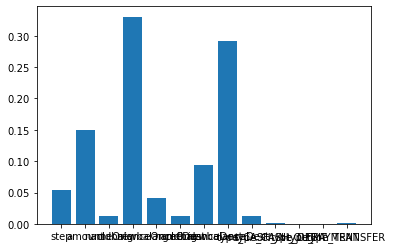

In [18]:
model = DecisionTreeRegressor()

model.fit(X, y)
importance = model.feature_importances_
for i,v in zip(X.columns, importance):
	print('Feature: %s, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar(list(X.columns), list(importance))
pyplot.show()

In [26]:
important_columns = [x[0] for x in sorted(zip(X.columns, importance), key=lambda x: x[1])[8:]]
important_columns

['step', 'oldbalanceDest', 'amount', 'newbalanceDest', 'oldbalanceOrg']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=14)
X_train.shape, X_test.shape

((4262955, 13), (2099665, 13))

Verifico distribución de type en los tests

In [28]:
print("type_PAYMENT: " + str((X_train.query("type_PAYMENT == 1")['type_PAYMENT'].sum() / len(X_train['type_PAYMENT'])) * 100))
print("type_TRANSFER: " + str((X_train.query("type_TRANSFER == 1")['type_TRANSFER'].sum() / len(X_train['type_PAYMENT'])) * 100))
print("type_DEBIT: " + str((X_train.query("type_DEBIT == 1")['type_DEBIT'].sum() / len(X_train['type_PAYMENT'])) * 100))
print("type_CASH_OUT: " + str((X_train.query("type_CASH_OUT == 1")['type_CASH_OUT'].sum() / len(X_train['type_PAYMENT'])) * 100))
print("type_CASH_IN: " + str((X_train.query("type_CASH_IN == 1")['type_CASH_IN'].sum() / len(X_train['type_PAYMENT'])) * 100))

type_PAYMENT: 33.816683497714614
type_TRANSFER: 8.377193754097803
type_DEBIT: 0.651660643849161
type_CASH_OUT: 35.18195711660104
type_CASH_IN: 21.97250498773738


In [29]:
print("type_PAYMENT: " + str((X_test.query("type_PAYMENT == 1")['type_PAYMENT'].sum() / len(X_test['type_PAYMENT'])) * 100))
print("type_TRANSFER: " + str((X_test.query("type_TRANSFER == 1")['type_TRANSFER'].sum() / len(X_test['type_PAYMENT'])) * 100))
print("type_DEBIT: " + str((X_test.query("type_DEBIT == 1")['type_DEBIT'].sum() / len(X_test['type_PAYMENT'])) * 100))
print("type_CASH_OUT: " + str((X_test.query("type_CASH_OUT == 1")['type_CASH_OUT'].sum() / len(X_test['type_PAYMENT'])) * 100))
print("type_CASH_IN: " + str((X_test.query("type_CASH_IN == 1")['type_CASH_IN'].sum() / len(X_test['type_PAYMENT'])) * 100))

type_PAYMENT: 33.810393562782636
type_TRANSFER: 8.372430840157834
type_DEBIT: 0.6501989603103353
type_CASH_OUT: 35.134604806004766
type_CASH_IN: 22.03237183074443


Oversampling

SMOTE

In [30]:
over_sampler = SMOTE(k_neighbors=2)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({0: 4257537, 1: 4257537})
Testing target statistics: Counter({0: 2096870, 1: 2795})


Learning..

LinearSVC
scaled


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


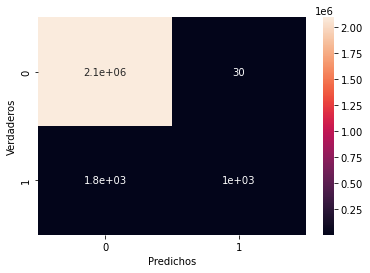

LinearSVC
stratify_scaled


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


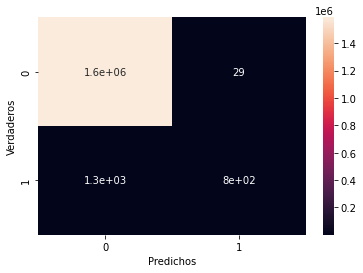

LinearSVC
smote


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


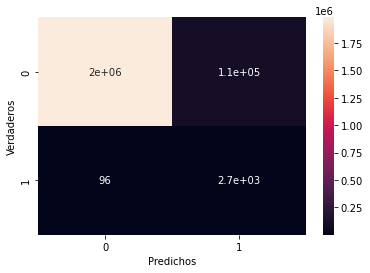

LogisticRegressionCV
normal


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

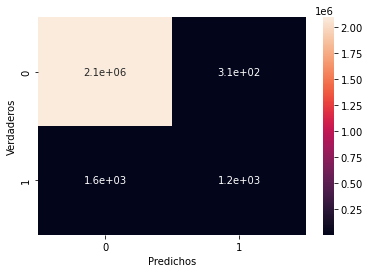

LogisticRegressionCV
normal_important_columns


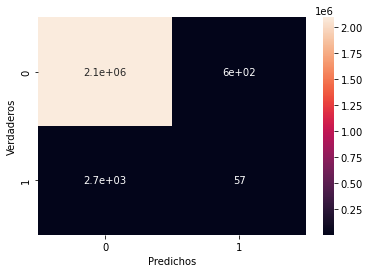

LogisticRegressionCV
smote


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

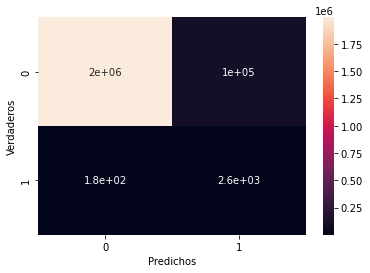

LogisticRegressionCV
smote_important_columns


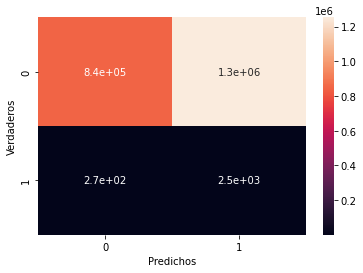

LogisticRegressionCV_class_weight
normal


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

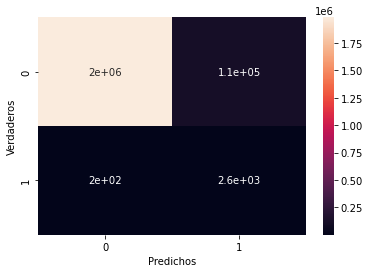

LogisticRegressionCV_class_weight
normal_important_columns


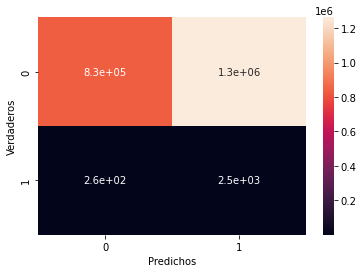

LogisticRegressionCV_class_weight
smote


/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ezefernandez/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

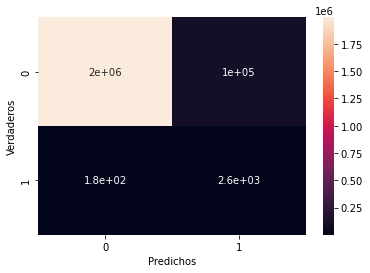

LogisticRegressionCV_class_weight
smote_important_columns


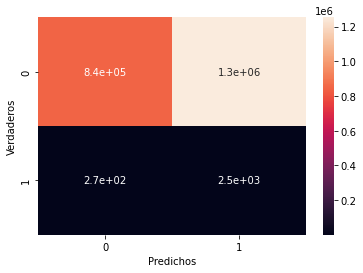

RandomForest
normal


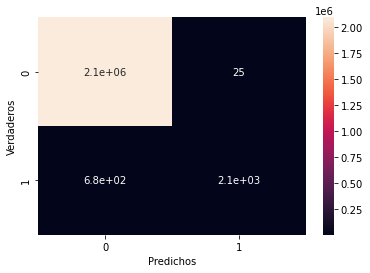

RandomForest
normal_important_columns


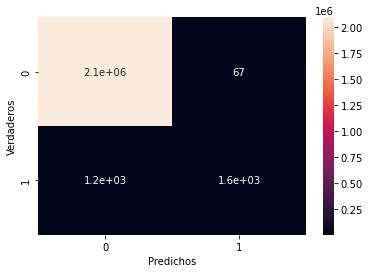

RandomForest
smote


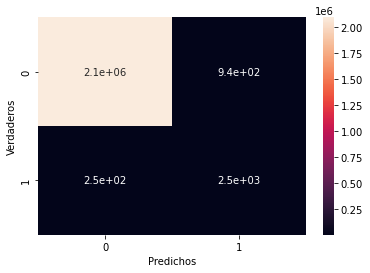

RandomForest
smote_important_columns


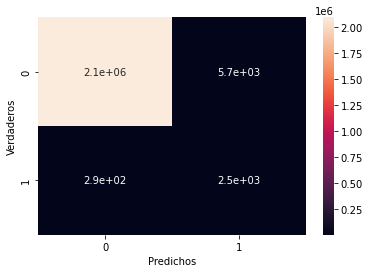

RandomForest_class_weight
normal


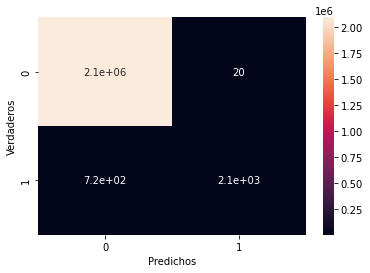

RandomForest_class_weight
normal_important_columns


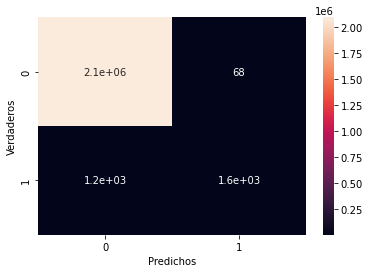

RandomForest_class_weight
smote


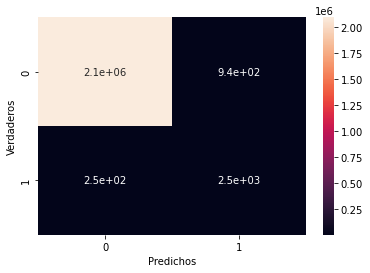

RandomForest_class_weight
smote_important_columns


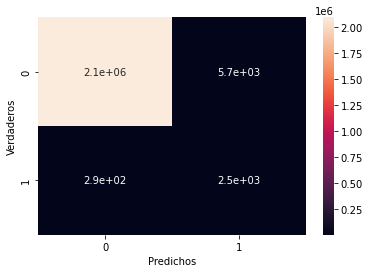

                                  normal_accuracy_score        normal_gain  \
LogisticRegressionCV                           0.999092  74730505308.62975   
LogisticRegressionCV_class_weight              0.946533  71378524968.47813   
RandomForest                                   0.999667  74692928819.54167   
RandomForest_class_weight                       0.99965  74695455966.25963   

                                  normalscore  \
LogisticRegressionCV                 0.999092   
LogisticRegressionCV_class_weight    0.946533   
RandomForest                         0.999667   
RandomForest_class_weight             0.99965   

                                             normalconfusion_matrix  \
LogisticRegressionCV                 [[2096560, 310], [1597, 1198]]   
LogisticRegressionCV_class_weight  [[1984805, 112065], [197, 2598]]   
RandomForest                           [[2096845, 25], [675, 2120]]   
RandomForest_class_weight              [[2096850, 20], [715, 2080]]   

       

In [33]:
# Modelos a ensayar.
models = [
    ("LogisticRegressionCV", LogisticRegressionCV(random_state=42, solver='lbfgs', max_iter=100)),
    ("LogisticRegressionCV_class_weight", LogisticRegressionCV(random_state=42, solver='lbfgs', max_iter=100, class_weight='balanced')),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("RandomForest_class_weight", RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    
]
models_svc = [
    ("LinearSVC", LinearSVC(random_state=42, tol=1e-5,max_iter=100))
]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_stratify, X_test_stratify, y_train_stratify, y_test_stratify = train_test_split(X, y, test_size=0.25, random_state=23,stratify=y)
X_train_stratify_scaled = scaler.fit_transform(X_train_stratify)
X_test_stratify_scaled = scaler.fit_transform(X_test_stratify)

# Aquí almacenaremos los resultados.
results = {}
models_trained = {}
results_svc = {}
models_trained_svc = {}

# Etrenamos cada modelo svc y almacenamos los resultados.
for m in models_svc:
    model_name = m[0]
    results_svc[model_name] = {}
    models_trained_svc[model_name] = {}
    model = clone(m[1])
    
    scenario = "scaled"
    print(model_name)
    print(scenario)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, predictions)
    results_svc[model_name][scenario + "_accuracy_score"] = acc
    ganancia = gain(predictions, y_test, X_test['amount'])
    results_svc[model_name][scenario + "_gain"] = str(ganancia)
    results_svc[model_name][scenario + "score"] = model.score(X_test_scaled,y_test)
    models_trained_svc[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results_svc[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

    scenario = "stratify_scaled"
    print(model_name)
    print(scenario)
    model.fit(X_train_stratify_scaled, y_train_stratify)
    predictions = model.predict(X_test_stratify_scaled)
    acc = accuracy_score(y_test_stratify, predictions)
    results_svc[model_name][scenario + "_accuracy_score"] = accuracy_score(y_test_stratify, predictions)
    ganancia = gain(predictions, y_test, X_test['amount'])
    results_svc[model_name][scenario + "_gain"] = str(ganancia)
    results_svc[model_name][scenario + "score"] = model.score(X_test_stratify_scaled,y_test_stratify)
    models_trained_svc[model_name][scenario] = model
    results_svc[model_name][scenario + "confusion_matrix"] = confusion_matrix(y_test_stratify, predictions)
    sns.heatmap(confusion_matrix(y_test_stratify, predictions), annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()
    
    scenario = "smote"
    print(model_name)
    print(scenario)
    model.fit(X_res, y_res)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    results_svc[model_name][scenario + "_accuracy_score"] = acc
    ganancia = gain(predictions, y_test, X_test['amount'])
    results_svc[model_name][scenario + "_gain"] = str(ganancia)
    results_svc[model_name][scenario + "score"] = model.score(X_test,y_test)
    models_trained_svc[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results_svc[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()
    
# Etrenamos cada modelo y almacenamos los resultados.
for m in models:
    model_name = m[0]
    results[model_name] = {}
    models_trained[model_name] = {}
    model = clone(m[1])
    
    scenario = "normal"
    print(model_name)
    print(scenario)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    ganancia = gain(predictions, y_test, X_test['amount'])
    acc = accuracy_score(y_test, predictions)
    results[model_name][scenario + "_accuracy_score"] = acc
    results[model_name][scenario + "_gain"] = str(ganancia)
    results[model_name][scenario + "score"] = model.score(X_test,y_test)
    models_trained[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()
    
    scenario = "normal_important_columns"
    print(model_name)
    print(scenario)
    model = clone(m[1])
    model.fit(X_train[important_columns], y_train)
    predictions = model.predict(X_test[important_columns])
    acc = accuracy_score(y_test, predictions)
    results[model_name][scenario + "_accuracy_score"] = acc
    ganancia = gain(predictions, y_test, X_test['amount'])
    results[model_name][scenario + "_gain"] = str(ganancia)
    results[model_name][scenario + "score"] = model.score(X_test[important_columns],y_test)
    models_trained[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

    scenario = "smote"
    print(model_name)
    print(scenario)
    model.fit(X_res, y_res)
    predictions = model.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    results[model_name][scenario + "_accuracy_score"] =acc = accuracy_score(y_test, predictions)
    ganancia = gain(predictions, y_test, X_test['amount'])
    results[model_name][scenario + "_gain"] = str(ganancia)
    results[model_name][scenario + "score"] = model.score(X_test,y_test)
    models_trained[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

    scenario = "smote_important_columns"
    print(model_name)
    print(scenario)
    model = clone(m[1])
    model.fit(X_res[important_columns], y_res)
    predictions = model.predict(X_test[important_columns])
    acc = accuracy_score(y_test, predictions)
    results[model_name][scenario + "_accuracy_score"] = acc
    ganancia = gain(predictions, y_test, X_test['amount'])
    results[model_name][scenario + "_gain"] = str(ganancia)
    results[model_name][scenario + "score"] = model.score(X_test[important_columns],y_test)
    models_trained[model_name][scenario] = model
    conf_matrix = confusion_matrix(y_test, predictions)
    results[model_name][scenario + "confusion_matrix"] = conf_matrix
    sns.heatmap(conf_matrix, annot=True)
    plt.ylabel('Verdaderos')
    plt.xlabel('Predichos')
    plt.show()

df_results = pd.DataFrame(results).T
print(df_results)

df_results_svc = pd.DataFrame(results_svc).T
print(df_results_svc)

In [34]:
df_results

,normal_accuracy_score,normal_gain,normalscore,normalconfusion_matrix,normal_important_columns_accuracy_score,normal_important_columns_gain,normal_important_columnsscore,normal_important_columnsconfusion_matrix,smote_accuracy_score,smote_gain,smotescore,smoteconfusion_matrix,smote_important_columns_accuracy_score,smote_important_columns_gain,smote_important_columnsscore,smote_important_columnsconfusion_matrix
LogisticRegressionCV,0.999092,74730505308.62975,0.999092,"[[2096560, 310], [1597, 1198]]",0.998411,75339620797.85567,0.998411,"[[2096271, 599], [2738, 57]]",0.950071,71673142748.13261,0.950071,"[[1992214, 104656], [178, 2617]]",0.403072,20736772970.88378,0.403072,"[[843792, 1253078], [270, 2525]]"
LogisticRegressionCV_class_weight,0.946533,71378524968.47813,0.946533,"[[1984805, 112065], [197, 2598]]",0.39857,20097820314.424118,0.39857,"[[834332, 1262538], [264, 2531]]",0.950071,71673142748.13261,0.950071,"[[1992214, 104656], [178, 2617]]",0.403072,20736772970.88378,0.403072,"[[843792, 1253078], [270, 2525]]"
RandomForest,0.999667,74692928819.54167,0.999667,"[[2096845, 25], [675, 2120]]",0.999399,74712828883.57365,0.999399,"[[2096803, 67], [1195, 1600]]",0.999431,74647134257.4634,0.999431,"[[2095925, 945], [250, 2545]]",0.997127,74543391763.07759,0.997127,"[[2091127, 5743], [289, 2506]]"
RandomForest_class_weight,0.99965,74695455966.25963,0.99965,"[[2096850, 20], [715, 2080]]",0.999391,74715503438.24371,0.999391,"[[2096802, 68], [1211, 1584]]",0.999431,74647134257.4634,0.999431,"[[2095925, 945], [250, 2545]]",0.997127,74543391763.07759,0.997127,"[[2091127, 5743], [289, 2506]]"


In [35]:
df_results_svc

,scaled_accuracy_score,scaled_gain,scaledconfusion_matrix,scaledscore,smote_accuracy_score,smote_gain,smoteconfusion_matrix,smotescore,stratify_scaled_accuracy_score,stratify_scaled_gain,stratify_scaledconfusion_matrix,stratify_scaledscore
LinearSVC,0.999149,74762808925.01389,"[[2096840, 30], [1756, 1039]]",0.999149,0.945933,72252310417.41136,"[[1983444, 113426], [96, 2699]]",0.945933,0.999195,57103150306.73123,"[[1588573, 29], [1252, 801]]",0.999195


Los metodos que maximizaron la ganancia fueron:
* LogisticRegressionCV considerando solo columnas importantes
* RandomForest usando smote
* RandomForest con class_weight
* LinearSVC usando StandarScaler

Analizando las matrices de confusión:
* LinearSVC con standar scaler dio solo 30 falsos positivos, aunque no predijo bien los casos fraudulentos
* LogisticRegressionCV prefijo con poca presición los casos fraudulentos
* RandomForest tuvo una tasa de falsos positivos y negativos considerables pero tuvo mas presición en ambos casos que los modelos vistos anteriormente
* RandomForest con datos normales usando class_weight tuvo una tasa muy baja de falsos positivos, y una presición mejor que la mayoría de los modelos en caoss de fraude.

Por esto nos quedamos con el modelo Random Forest usando class weight, cuyas métricas fueron las siguientes

In [54]:
df_results.shape

(4, 16)

In [62]:
print("accuracy: " + str(df_results.iloc[-1:]['normal_accuracy_score'][0]))
print("gain: " + str(df_results.iloc[-1:]['normal_gain'][0]))
print("score: " + str(df_results.iloc[-1:]['normalscore'][0]))
print("confusion matrix: " + str(df_results.iloc[-1:]['normalconfusion_matrix'][0]))

accuracy: 0.9996499441577585
gain: 74695455966.25963
score: 0.9996499441577585
confusion matrix: [[2096850      20]
 [    715    2080]]


In [31]:
# Ganancia
def gain(prediction, y_test, amounts):
    accumulated_gain = 0

    for p, y, a in zip(prediction, y_test, amounts):
        if p == 0 & y == 0:
            accumulated_gain += 0.20 * a
        #if p == 1 & y == 0:
            # no gain and no lost
        if p == 0 & y == 1:
            accumulated_gain += -a

        #if p == 1 & y == 1:
            # no gain and no lost 
    return accumulated_gain